In [2]:
#___________________________________________________________________________________________________________________
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

import matplotlib.pyplot as plt
import sys
import os
sys.path.append("../src/")
from sub_mesh        import * 
from sub_data        import * 
from sub_plot        import * 
from sub_climatology import *
from sub_index       import *
from sub_utility     import *
from colormap_c2c    import colormap_c2c
import time as time 

## > <u>Load meshes:</u> 

In [3]:
# which_mesh = 'GEBCO15sec_smth+crctDS-610'
# which_mesh = 'GEBCO15sec_smth+crctISR-363'
# which_mesh = 'GEBCO15sec_smth+crctFBC-990'
# which_mesh = 'GEBCO15sec_smth+crctRT-738'
# which_mesh = 'GEBCO15sec_smth+crctGS-210'
which_mesh = 'GEBCO15sec_smth+crctFS-1752'
# which_mesh = 'ref'
if which_mesh.lower()== 'ref': meshpath='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
else                         : meshpath='/work/ollie/pscholz/mesh_fesom2.0/core2_'+which_mesh+'@elem/'
mesh=load_mesh_fesom2(meshpath, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_GEBCO15sec_smth+crctFS-1752@elem
 > load  *.pckl file: tripyview_fesom2_core2_GEBCO15sec_smth+crctFS-1752@elem.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_GEBCO15sec_smth+crctFS-1752@elem
 > id              = core2_GEBCO15sec_smth+crctFS-1752@elem
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


## > <u>Load topo based on: elvls.out, nlvls.out</u> 

<IPython.core.display.Javascript object>


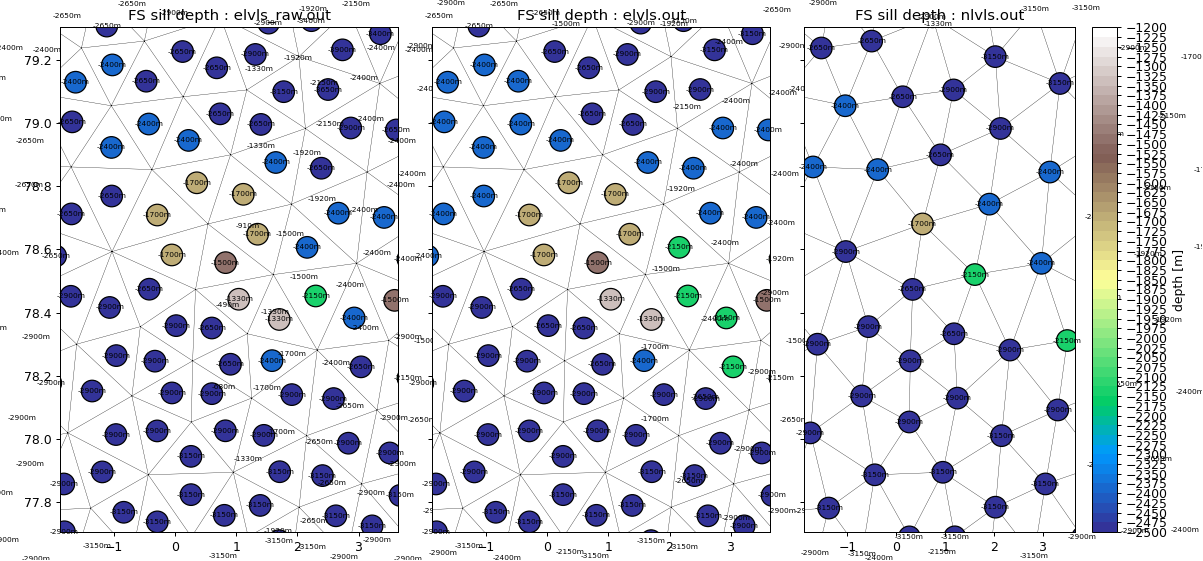

In [9]:
tunedep_boxlist = list()
# tunedep_boxlist.append([  [ -29.00,  -25.00,  65.00,  67.50],'Denmark_Strait']) # Denmark Strait
# tunedep_boxlist.append([ [ -13.00,   -7.50,  62.25,  64.75], 'Iceland_Scotland_Ridge']) # Iceland Scotland Ridge
# tunedep_boxlist.append([ [  -9.50,   -3.00,  59.50,  62.00], 'Faroe_Bank_Channel'])
# tunedep_boxlist.append([ [  -20  ,   -5   ,  52   ,  59.5 ], 'Rockall_Trough'    ]) # Rockall Trough
# tunedep_boxlist.append([ [-9, -2, 35.0, 37.0],'GS']) # Gibraltar strait    
tunedep_boxlist.append([ [-5, 7, 76.0, 83.0],'FS']) # Gibraltar strait    
# tunedep_boxlist.append([ [ -13.00,   -7.50,  62.25,  64.75],'ISN']) 
# tunedep_boxlist.append([ [  -8.50,   -3.00,  59.25,  62.00],'ISS']) 

    
cname        = 'terrain'
do_elem      = True

#_____________________________________________________________________________________________
file_content = pa.read_csv(os.path.join(mesh.path,'elvls_raw.out'), delim_whitespace=True, skiprows=0, names=['numb_of_lev'])
e_z_raw      = file_content.values.astype('uint16') - 1
e_z_raw      = mesh.zlev[e_z_raw.squeeze()]

file_content = pa.read_csv(os.path.join(mesh.path,'elvls.out'), delim_whitespace=True, skiprows=0, names=['numb_of_lev'])
e_z          = file_content.values.astype('uint16') - 1
e_z          = mesh.zlev[e_z.squeeze()]

file_content = pa.read_csv(os.path.join(mesh.path,'nlvls.out'), delim_whitespace=True, skiprows=0, names=['numb_of_lev'])
n_z          = file_content.values.astype('uint16') - 1
n_z          = mesh.zlev[n_z.squeeze()]

#_____________________________________________________________________________________________
# idxe         = do_boxmask(mesh,tunedep_boxlist[0][0], do_elem=True)
idxn         = do_boxmask(mesh,tunedep_boxlist[0][0], do_elem=False)
idxe         = idxn[mesh.e_i].sum(axis=1)>1
e_x, e_y     = mesh.n_x[mesh.e_i].sum(axis=1)/3.0,  mesh.n_y[mesh.e_i].sum(axis=1)/3.0
tri          = Triangulation(mesh.n_x, mesh.n_y,mesh.e_i[idxe])

#_____________________________________________________________________________________________
cmin, cmax   = [-2500, -1200]
# cmin, cmax   = [-1600, -500]
# if do_elem: cmin = e_z[idxe].min()
# else      : cmin = n_z[idxn].min()    
clevel       = np.arange(cmin, cmax+1, 25)

#_____________________________________________________________________________________________
fig, ax=plt.subplots(1,3,figsize=[15,7], sharex=True, sharey=True,
                    gridspec_kw=dict(left=0.05, bottom=0.05, right=0.950, top=0.950, wspace=0.1, hspace=0.1,),)
ssize = 300
#_____________________________________________________________________________________________
hs=ax[0].scatter(e_x[idxe], e_y[idxe],ssize, e_z_raw[idxe],  vmin=clevel[0], vmax=clevel[-1], cmap=plt.get_cmap(cname, clevel.size-1), edgecolor='k')  
ax[0].triplot(tri, linewidth=0.25, color= 'k')
txt_x, txt_y, txt_v= e_x[idxe], e_y[idxe], e_z_raw[idxe] 
for ii in range(0,len(txt_x)):
    ax[0].text(txt_x[ii], txt_y[ii], '{:.0f}m'.format(txt_v[ii]), dict({'horizontalalignment':'center', 'verticalalignment':'center','fontsize':6}) )
ax[0].set_title(tunedep_boxlist[0][1]+' sill depth : elvls_raw.out')  

#_____________________________________________________________________________________________
hs=ax[1].scatter(e_x[idxe], e_y[idxe],ssize, e_z[idxe],  vmin=clevel[0], vmax=clevel[-1], cmap=plt.get_cmap(cname, clevel.size-1), edgecolor='k')  
ax[1].triplot(tri, linewidth=0.25, color= 'k')
txt_x, txt_y, txt_v= e_x[idxe], e_y[idxe], e_z[idxe] 
for ii in range(0,len(txt_x)):
    ax[1].text(txt_x[ii], txt_y[ii], '{:.0f}m'.format(txt_v[ii]), dict({'horizontalalignment':'center', 'verticalalignment':'center','fontsize':6}) )
ax[1].set_title(tunedep_boxlist[0][1]+' sill depth : elvls.out')  

#_____________________________________________________________________________________________
ax[2].triplot(tri, linewidth=0.25, color= 'k',zorder=-1)
hs=ax[2].scatter(mesh.n_x[idxn], mesh.n_y[idxn], ssize, n_z[idxn],  vmin=clevel[0], vmax=clevel[-1], cmap=plt.get_cmap(cname, clevel.size-1), edgecolor='k')  
txt_x, txt_y, txt_v= mesh.n_x[idxn], mesh.n_y[idxn], n_z[idxn] 
for ii in range(0,len(txt_x)):
    ax[2].text(txt_x[ii], txt_y[ii], '{:.0f}m'.format(txt_v[ii]), dict({'horizontalalignment':'center', 'verticalalignment':'center','fontsize':6, 'fontweight':'normal'}) )
ax[2].set_title(tunedep_boxlist[0][1]+' sill depth : nlvls.out')     

#_____________________________________________________________________________________________
for axi in ax.flatten():
#     axi.axis('equal')
    axi.set_xlim(tunedep_boxlist[0][0][0], tunedep_boxlist[0][0][1])
    axi.set_ylim(tunedep_boxlist[0][0][2], tunedep_boxlist[0][0][3])
    
#_____________________________________________________________________________________________
cbar = plt.colorbar(hs, ax=ax[2], ticks=clevel, label='depth [m]')

#_____________________________________________________________________________________________
# save figure based on do_save contains either None or pathname
do_save = None #'/home/ollie/pscholz/figures/test_topo@denmark_strait/topo@denmark_strait_'+which_mesh+'_elvls_nlvls.png'
do_savefigure(do_save)

## > <u>Select depth of  scatter points class</u> 

<u>Mouse Input:</u> <br>

    [left  ] ... select certain scatter point (green ring) <br>
    [right ] ... zoom out to original xlim, ylim <br>

<u>Keyboard Input:</u> <br>

    [  c   ]   ... choose depth value for certain scatter points (value is sleected by slider) <br>
    [  e   ]   ... finish choosing exit interactive mode <br>
    [  +   ]   ... zoom in  <br>
    [  -   ]   ... zoom in  <br>
    [  up  ]   ... move up  <br>
    [ down ]   ... move down  <br>
    [ left ]   ... move left  <br>
    [ right]   ... move right  <br>
           